<a href="https://colab.research.google.com/github/tdiggelm/nn-experiments/blob/master/attention_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.corpus import movie_reviews
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from keras import activations
from keras import backend as K
from keras import optimizers
from keras import datasets
from IPython.core.display import HTML
from sklearn.metrics import classification_report
!pip install keras-tcn
from tcn import TCN

Using TensorFlow backend.


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Todo

* try out `Scaled Dot-Product Attention` of `arXiv:1706.03762` for self-attention
  * Querys = random weights (Dense) -OR- embedded input, Keys = Values = Hidden states LSTM
* Apply fc layers seperately on each sequence encoded input (use `TimeDistributed`)
* Normalize between the layers

In [4]:
MAX_SEQ_LEN = 250
#MAX_NUM_WORDS = 10000

(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data()

X_train = pad_sequences(X_train, MAX_SEQ_LEN)
X_test = pad_sequences(X_test, MAX_SEQ_LEN)

word_index = datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

index_word = {}
for k,v in word_index.items():
  index_word[v] = k

1646592/1641221 [==============================] - 4s 3us/step


In [0]:
import os
from keras import initializers
from keras import layers
def get_glove_embedding(word_index, embedding_dim=100, input_length=None, trainable=True):
  if not os.path.isfile("glove.6B.%dd.txt" % embedding_dim):
    !wget "http://nlp.stanford.edu/data/glove.6B.zip"
    !unzip "glove.6B.zip"

  # get glove coeff matrix
  embeddings_index = {}
  with open("glove.6B.%dd.txt" % embedding_dim, encoding="utf-8") as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))

  # prepare pre-learned embedding matrix
  #num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
  num_words = len(word_index) + 1
  embedding_matrix = np.zeros((num_words, embedding_dim))
  for word, i in word_index.items():
      #if i > MAX_NUM_WORDS:
      #    continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

  return layers.Embedding(num_words, embedding_dim, 
                   input_length=input_length, 
                   embeddings_initializer=initializers.Constant(embedding_matrix),
                   trainable=trainable)

def frobenius_regularizer(weight_matrix):
  A = K.softmax(weight_matrix, axis=1)
  AT = K.transpose(A)
  M = K.dot(A, AT)
  d = K.shape(M)[1]
  return 1.0 * K.sum(K.abs(M-K.eye(d))**2)

def build_model(
    embedding_dim=100,
    n_hidden=50,
    da=350,
    r=30,
    dropout=0.5,
    lr=0.001, 
    clipnorm=0.1,
    n_dense=1024,
    penalize=True,
    attention=True
):
  regularizer = frobenius_regularizer if penalize else None
  inputs = layers.Input(shape=(MAX_SEQ_LEN,))
  embedding = get_glove_embedding(word_index,
                                  embedding_dim=embedding_dim)(inputs)
  H = layers.Bidirectional(layers.CuDNNLSTM(n_hidden,
                                            return_sequences=True,
                                           ))(embedding)
  if attention:
    #--- BEGIN ATTENTION (arXiv:1703.03130)
    WS1 = layers.Dense(da, activation='tanh')(H)
    WS1 = layers.Dropout(dropout)(WS1)
    WS2 = layers.Dense(r, kernel_regularizer=regularizer)(WS1)
    WS2 = layers.Dropout(dropout)(WS2)
    A = layers.Softmax(axis=1, name='attention_weights')(WS2)
    M = layers.Dot(axes=1)([A, H])
    H = M
    #--- END ATTENTION

  reduced = layers.Lambda(lambda x: K.mean(x, axis=1))(H)
  dense = layers.Dense(n_dense, activation='relu')(reduced)
  dense = layers.Dropout(dropout)(dense)
  dense = layers.Dense(n_dense, activation='relu')(dense)
  dense = layers.Dropout(dropout)(dense)
  output = layers.Dense(1, activation='sigmoid')(dense)
  model = models.Model(inputs, output)
  optimizer = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  model.compile(optimizer=optimizer, loss=['binary_crossentropy'],
                metrics=['accuracy'])
  return model

In [116]:
model = build_model(**{
    'embedding_dim': 100,
    'clipnorm': 0.5,
    'da': 100,
    'dropout': 0.5,
    'lr': 0.001,
    'n_dense': 1024,
    'n_hidden': 50,
    'r': 30,
    'attention': True,
    'penalize': True
})
model.summary()

Found 400000 word vectors.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 250, 100)     8858800     input_26[0][0]                   
__________________________________________________________________________________________________
bidirectional_34 (Bidirectional (None, 250, 100)     60800       embedding_25[0][0]               
__________________________________________________________________________________________________
dense_104 (Dense)               (None, 250, 100)     10100       bidirectional_34[0][0]           
__________________________________________________________________________________

In [117]:
history = model.fit(X_train, y_train, validation_data=(X_test[:1000], y_test[:1000]),
                    epochs=3, verbose=1, batch_size=32)

Train on 25000 samples, validate on 1000 samples
Epoch 1/3
25000/25000 [==============================] - 78s 3ms/step - loss: 103.7268 - acc: 0.8219 - val_loss: 101.6236 - val_acc: 0.8840
Epoch 2/3
25000/25000 [==============================] - 69s 3ms/step - loss: 97.6721 - acc: 0.9194 - val_loss: 91.9189 - val_acc: 0.8810
Epoch 3/3
25000/25000 [==============================] - 69s 3ms/step - loss: 83.7658 - acc: 0.9666 - val_loss: 78.1586 - val_acc: 0.8690


In [118]:
y_pred = model.predict(X_test, verbose=1)
print(classification_report(y_test, y_pred>0.5))

25000/25000 [==============================] - 30s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     12500
           1       0.84      0.91      0.87     12500

   micro avg       0.87      0.87      0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



Text(0.5, 0, 'epoch')

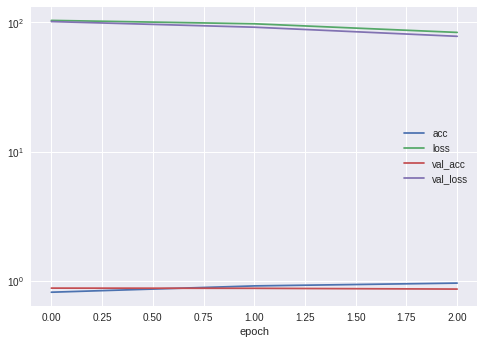

In [119]:
ax = pd.DataFrame(history.history).plot(logy=True)
ax.set_xlabel("epoch")

In [0]:
def highlight_sentence(index_word, seqs, atts, y_true, y_pred, r='mean'):
  html = ''
  for seq, attention, yt, yp in zip(seqs, atts, y_true, y_pred):
    begin = (seq>0).argmax()
    mean_att = None
    if r == 'mean':
      mean_att = attention.mean(axis=1)
    else:
      mean_att = attention[:, r]
    renorm = mean_att[begin:]/mean_att[begin:].max()
    para = ''
    for idx, score in zip(seq[begin:], renorm):
      word = ''
      try:
        word = index_word[idx]
      except KeyError:
        pass
      para += '<span style="background-color: rgba(100%%,0%%,0%%,%d%%)">%s</span> ' % ((score)*100, word)
    titel = '<h3>label (true/prediction): %d/%d</h3>' % (yt, yt)
    html += titel + '<p>' + para + '</p>'
  return html

model_att = models.Model(model.input, model.get_layer('attention_weights').output)

In [121]:
start = 50
n = 10
X = X_test[start:start+n]
y_true = y_test[start:start+n]
y_pred = model.predict(X)>0.5

HTML(highlight_sentence(index_word, X, model_att.predict(X), y_true, y_pred, r='mean'))